# Project M2 (rename it)

First we import the needed libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

sns.set_style("darkgrid")
%matplotlib inline

#load the statistical libraries
from scipy import stats

from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge
# from sklearn.preprocessing import OneHotEncoder
# from pandas.plotting import scatter_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, auc, roc_curve
from statsmodels.stats import diagnostic
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf

from ipywidgets import interact
from IPython.display import HTML,Javascript, display
from sklearn import preprocessing

## Data preprocessing
In this project, we will investigate in to two beer rating datasets, BeerAdvocate and RateBeer. Both datasets contain ```user```, ```brewery```, ```beeer``` and ```rating```.

##### Note of rating files
Since the **rating** files are txt files of about several gigabytes in size, we cannot handle it simultaneously. Therefore, we **sliced** them to several small pieces and then **combined** them into '.csv' files.

The slicing process is extremely time-consuming, thus we won't put the code here. The method is just parsing the file line by line and add some number restrictions for each bulk. And transfer the '.txt' file to '.csv' file.

We also filtered out the beer data which has less than 120 ratings. In this way each beer has enough rating for data analysis.**Add Why**

We put the processed rating data in the same directory as this ipython notebook and name them as **after_pro_data_ba.csv** and **after_pro_data_rb.csv** for **BeerAdvocate** and **RateBeer** respectively.

### Handle the missing value and initial data filtering

#### BeerAdvocate

In [2]:
# Load ratings data from BeerAdvocate
df_rating_ba = pd.read_csv('after_pro_data_ba.csv')
df_rating_ba = df_rating_ba.drop(columns=['Unnamed: 0'])
print(f'Currently, there are {len(df_rating_ba)} ratings on BeerAdvocate website')
df_rating_ba.head()

Currently, there are 6264473 ratings on BeerAdvocate website


,beer_name,beer_id,brewery_name,brewery_id,style,abv,date,user_name,user_id,appearance,aroma,palate,taste,overall,rating,text,review
0,Caffrey's Irish Ale,825,Thomas Caffrey Brewing Co.,297,Irish Red Ale,3.8,1500112800,GregKobeArntz24,gregkobearntz24.1206160,4.5,4.75,4.25,4.5,4.50,4.54,NaN,False
1,Caffrey's Irish Ale,825,Thomas Caffrey Brewing Co.,297,Irish Red Ale,3.8,1483182000,awjess,awjess.1185716,4.5,4.00,4.25,4.0,4.25,4.11,"Look - Has a nice foamy head, Feel - Creamy ...",False
2,Caffrey's Irish Ale,825,Thomas Caffrey Brewing Co.,297,Irish Red Ale,3.8,1468317600,fr0wn3r,fr0wn3r.862994,3.0,3.25,3.00,3.0,3.00,3.06,NaN,False
3,Caffrey's Irish Ale,825,Thomas Caffrey Brewing Co.,297,Irish Red Ale,3.8,1459418400,Fatehunter,fatehunter.326927,4.0,3.25,4.00,3.5,3.50,3.52,Pours a finger of head on a hazy darker straw ...,True
4,Caffrey's Irish Ale,825,Thomas Caffrey Brewing Co.,297,Irish Red Ale,3.8,1450263600,MTLDOG,mtldog.920333,4.5,3.75,4.00,3.0,3.75,3.52,NaN,False


In [3]:
# The scoring attribute
column_ = ['appearance', 'aroma', 'palate', 'taste', 'overall']
print(f'There are {df_rating_ba [column_].isna().any(axis = 1).value_counts()[1]} rows have NAN values in BeerAdvocate')
print(f'There are {np.sum(df_rating_ba [column_].isna().sum(axis = 1)==5)} rows with 5 NAN values in BeerAdvocate')
compare_ba = df_rating_ba[df_rating_ba[column_].isna().any(axis = 1)]
compare_ba['rating'].describe()

There are 2971642 rows have NAN values in BeerAdvocate
There are 2971642 rows with 5 NAN values in BeerAdvocate


count    2.971642e+06
mean     3.902421e+00
std      6.835105e-01
min      1.000000e+00
25%      3.500000e+00
50%      4.000000e+00
75%      4.250000e+00
max      5.000000e+00
Name: rating, dtype: float64

Here we found if there is no overall score, there wouldn't be detailed scores about one beer. We also check the website manually, and found that we should rate the appearance, aroma, palate, taste, overall together.
However, these data all have the rating values. We don't think that these data are useful since we want to find some relationship of the detailed score to the rating and other perspectives. And since we will still have very large amout data after deleting them, we will just simply delete them.

In [4]:
#Delete all meaninigless lines
df_rating_ba = df_rating_ba[~df_rating_ba[column_].isna().any(axis = 1)]
df_rating_ba.shape

(3292831, 17)

The user_id in BeerAdvocate rating dataset are composed of both of name and id we want to keep the numeric id for simplicity.

In [5]:
#spilt the user_id in BeerAdvocate
def str_split(data):
    return data.split('.')[1]
df_rating_ba['user_id'] = df_rating_ba['user_id'].apply(str_split)
df_rating_ba.head()

,beer_name,beer_id,brewery_name,brewery_id,style,abv,date,user_name,user_id,appearance,aroma,palate,taste,overall,rating,text,review
0,Caffrey's Irish Ale,825,Thomas Caffrey Brewing Co.,297,Irish Red Ale,3.8,1500112800,GregKobeArntz24,1206160,4.5,4.75,4.25,4.5,4.50,4.54,NaN,False
1,Caffrey's Irish Ale,825,Thomas Caffrey Brewing Co.,297,Irish Red Ale,3.8,1483182000,awjess,1185716,4.5,4.00,4.25,4.0,4.25,4.11,"Look - Has a nice foamy head, Feel - Creamy ...",False
2,Caffrey's Irish Ale,825,Thomas Caffrey Brewing Co.,297,Irish Red Ale,3.8,1468317600,fr0wn3r,862994,3.0,3.25,3.00,3.0,3.00,3.06,NaN,False
3,Caffrey's Irish Ale,825,Thomas Caffrey Brewing Co.,297,Irish Red Ale,3.8,1459418400,Fatehunter,326927,4.0,3.25,4.00,3.5,3.50,3.52,Pours a finger of head on a hazy darker straw ...,True
4,Caffrey's Irish Ale,825,Thomas Caffrey Brewing Co.,297,Irish Red Ale,3.8,1450263600,MTLDOG,920333,4.5,3.75,4.00,3.0,3.75,3.52,NaN,False


#### RateBeer
We will do the similar process to the RateBeer dataset.

In [6]:
# Load rating data on RateBeer website
df_rating_rb = pd.read_csv('after_pro_data_rb.csv')
df_rating_rb = df_rating_rb.drop(columns=['Unnamed: 0'])
print(f'Currently, there are {len(df_rating_rb)} ratings on RateBeer website')
df_rating_rb.head()

Currently, there are 3443337 ratings on RateBeer website


,beer_name,beer_id,brewery_name,brewery_id,style,abv,date,user_name,user_id,appearance,aroma,palate,taste,overall,rating,text
0,ABC Extra Stout,9226,Singapore Brewery (Asia Pacific Breweries-Hein...,547,Foreign Stout,7.0,1500199200,mcberko,95615,4,6,2,6,11,2.9,"330mL can, Cambodian version (8%), pours black..."
1,ABC Extra Stout,9226,Singapore Brewery (Asia Pacific Breweries-Hein...,547,Foreign Stout,7.0,1497780000,Grumbo,118968,3,7,4,6,12,3.2,Can at Johnâs courtesy of Henrik. Sri Lanka ...
2,ABC Extra Stout,9226,Singapore Brewery (Asia Pacific Breweries-Hein...,547,Foreign Stout,7.0,1497434400,alex_leit,243248,4,6,3,6,13,3.2,"Can, Myanmar, 8,0%, dark brown color, coffee f..."
3,ABC Extra Stout,9226,Singapore Brewery (Asia Pacific Breweries-Hein...,547,Foreign Stout,7.0,1491559200,gripweed57,60778,4,8,4,8,15,3.9,From old tasting notes. Pours an opaque black ...
4,ABC Extra Stout,9226,Singapore Brewery (Asia Pacific Breweries-Hein...,547,Foreign Stout,7.0,1486465200,fkoolen,261854,4,7,4,7,14,3.6,"Big bottle in Nyaungshwe, Myanmar. Really dark..."


In [7]:
print(f"Thera are {df_rating_rb[column_].isna().any(axis = 1).value_counts()[0]} rows don't have NAN value")
print(f'Thera are {np.sum(df_rating_rb [column_].isna().sum(axis = 1)==5)} rows with NAN value')
compare_rb = df_rating_rb[df_rating_rb[column_].isna().any(axis = 1)]
print("Since we don't have nan values we won't do the missing values handling here.")

Thera are 3443337 rows don't have NAN value
Thera are 0 rows with NAN value
Since we don't have nan values we won't do the missing values handling here.


### Datasets preparation and more filtering
#### BeerAdvocate
We first map the scale of each rating to 0-5 to make a consistency between the two datasets.

In [8]:
column_list = ['appearance', 'aroma', 'palate', 'taste', 'overall','rating']
list_value = df_rating_ba[column_list].values
min_max_scaler = preprocessing.MinMaxScaler()
list_value_scaler = min_max_scaler.fit_transform(list_value) * 5
data_temp_ba = pd.DataFrame(list_value_scaler,columns=column_list,index = df_rating_ba.index)
df_rating_ba[column_list] = data_temp_ba

df_rating_ba.head()

,beer_name,beer_id,brewery_name,brewery_id,style,abv,date,user_name,user_id,appearance,aroma,palate,taste,overall,rating,text,review
0,Caffrey's Irish Ale,825,Thomas Caffrey Brewing Co.,297,Irish Red Ale,3.8,1500112800,GregKobeArntz24,1206160,4.375,4.6875,4.0625,4.375,4.3750,4.4250,NaN,False
1,Caffrey's Irish Ale,825,Thomas Caffrey Brewing Co.,297,Irish Red Ale,3.8,1483182000,awjess,1185716,4.375,3.7500,4.0625,3.750,4.0625,3.8875,"Look - Has a nice foamy head, Feel - Creamy ...",False
2,Caffrey's Irish Ale,825,Thomas Caffrey Brewing Co.,297,Irish Red Ale,3.8,1468317600,fr0wn3r,862994,2.500,2.8125,2.5000,2.500,2.5000,2.5750,NaN,False
3,Caffrey's Irish Ale,825,Thomas Caffrey Brewing Co.,297,Irish Red Ale,3.8,1459418400,Fatehunter,326927,3.750,2.8125,3.7500,3.125,3.1250,3.1500,Pours a finger of head on a hazy darker straw ...,True
4,Caffrey's Irish Ale,825,Thomas Caffrey Brewing Co.,297,Irish Red Ale,3.8,1450263600,MTLDOG,920333,4.375,3.4375,3.7500,2.500,3.4375,3.1500,NaN,False


By doing some simple regression study we find there exist perfect linear relationship between 'overall', 'aroma', 'palate', 'taste', 'overall', 'rating'.

In [9]:
# Use linear regression to fit our data
mod_ba = smf.ols(formula='rating ~appearance + aroma + palate + taste + overall',data = df_rating_ba)
res_ba = mod_ba.fit()
print(res_ba.summary())
print(f'The R-squared is 1.000 so it is of perfect linear relationship.')

                            OLS Regression Results                            
Dep. Variable:                 rating   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 4.904e+10
Date:                Fri, 18 Nov 2022   Prob (F-statistic):               0.00
Time:                        20:44:57   Log-Likelihood:             1.4883e+07
No. Observations:             3292831   AIC:                        -2.977e+07
Df Residuals:                 3292825   BIC:                        -2.977e+07
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0003    8.3e-06     37.210      0.0

We also find that there exists some ratings that the **overall** score exceeds the average of the other 4 features(can do this due to the perfect linear relationship). We consider this situation as invalid ratings. Because in common sense, if the detailed features of a beer is good/bad the overall will not be bad/good. And we set the difference threshold to 1.5(in scale of 5).

In [10]:
df_rating_ba['average'] = df_rating_ba[['appearance','aroma','palate','taste']].mean(axis = 1)
df_rating_ba['diff'] = np.abs(df_rating_ba['overall']-df_rating_ba['average'])
df_rating_ba = df_rating_ba[df_rating_ba['diff'] <1.5]
df_rating_ba = df_rating_ba.drop(columns=['average','diff'])
df_rating_ba.shape

(3266748, 17)

In [11]:
# Load user data from BeerAdvocate
df_user_ba = pd.read_csv('BeerAdvocate/users.csv')
df_user_ba['user_id'] = df_user_ba['user_id'].apply(str_split)
df_user_ba.head()

,nbr_ratings,nbr_reviews,user_id,user_name,joined,location
0,7820,465,184925,nmann08,1.199704e+09,"United States, Washington"
1,2521,2504,163714,StJamesGate,1.191838e+09,"United States, New York"
2,1797,1143,19527,mdagnew,1.116410e+09,Northern Ireland
3,31,31,10867,helloloser12345,1.101380e+09,Northern Ireland
4,604,604,3708,cypressbob,1.069326e+09,Northern Ireland


In [12]:
# Load beer data from BeerAdvocate
df_beer_ba = pd.read_csv('BeerAdvocate/beers.csv')
df_beer_ba.head()

,beer_id,beer_name,brewery_id,brewery_name,style,nbr_ratings,nbr_reviews,avg,ba_score,bros_score,abv,avg_computed,zscore,nbr_matched_valid_ratings,avg_matched_valid_ratings
0,166064,Nashe Moskovskoe,39912,Abdysh-Ata (Абдыш Ата),Euro Pale Lager,0,0,NaN,NaN,NaN,4.7,NaN,NaN,0,NaN
1,166065,Nashe Pivovskoe,39912,Abdysh-Ata (Абдыш Ата),Euro Pale Lager,0,0,NaN,NaN,NaN,3.8,NaN,NaN,0,NaN
2,166066,Nashe Shakhterskoe,39912,Abdysh-Ata (Абдыш Ата),Euro Pale Lager,0,0,NaN,NaN,NaN,4.8,NaN,NaN,0,NaN
3,166067,Nashe Zhigulevskoe,39912,Abdysh-Ata (Абдыш Ата),Euro Pale Lager,0,0,NaN,NaN,NaN,4.0,NaN,NaN,0,NaN
4,166063,Zhivoe,39912,Abdysh-Ata (Абдыш Ата),Euro Pale Lager,0,0,NaN,NaN,NaN,4.5,NaN,NaN,0,NaN


In [13]:
# Load brewery data from BeerAdvocate
df_brewery_ba = pd.read_csv('BeerAdvocate/breweries.csv')
df_brewery_ba.head()

,id,location,name,nbr_beers
0,39912,Kyrgyzstan,Abdysh-Ata (Абдыш Ата),5
1,39913,Kyrgyzstan,Arpa (АРПА),1
2,39914,Kyrgyzstan,Bear Beer,4
3,39915,Kyrgyzstan,Blonder Pub,4
4,39916,Kyrgyzstan,Kellers Bier,2


In [14]:
# Merge data based on user id in order to get users' location
#user_region = df_user_ba[['user_id', 'location']]
region_ba = pd.merge(df_rating_ba, df_user_ba, how="left", left_on='user_id', right_on='user_id')

In [15]:
region_agg = region_ba[['location', 'beer_id']].groupby('location').agg('count')
region_agg = pd.DataFrame(region_agg.to_records())
region_agg.rename(columns={'beer_id':'count'}, inplace=True)
region_agg = region_agg.sort_values(by=['count'], ascending=False)
region_agg.reset_index(inplace=True, drop=True)
# Print top 20 region
region_agg.head(20)

,location,count
0,"United States, Pennsylvania",260952
1,"United States, California",235136
2,"United States, New York",209952
3,"United States, Illinois",201059
4,"United States, Massachusetts",178341
5,"United States, Ohio",136446
6,"United States, Texas",132515
7,"United States, New Jersey",109257
8,"United States, Florida",95612
9,"United States, Virginia",95248


#### RateBeer
First map to scale to 0-5 then filtered the invalid rating as previous steps

In [16]:
list_value_rb = df_rating_rb[column_list].values
list_value_scaler_rb = min_max_scaler.fit_transform(list_value_rb) * 5
data_temp_rb = pd.DataFrame(list_value_scaler_rb,columns=column_list,index = df_rating_rb.index)
df_rating_rb[column_list] = data_temp_rb

In [17]:
mod_rb = smf.ols(formula='rating ~appearance + aroma + palate + taste + overall',data =df_rating_rb)
res_rb = mod_rb.fit()
print(res_rb.summary())

                            OLS Regression Results                            
Dep. Variable:                 rating   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.529e+11
Date:                Fri, 18 Nov 2022   Prob (F-statistic):               0.00
Time:                        20:45:05   Log-Likelihood:             1.7073e+07
No. Observations:             3443337   AIC:                        -3.415e+07
Df Residuals:                 3443331   BIC:                        -3.415e+07
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   5.049e-06   3.86e-06      1.309      0.1

In [18]:
df_rating_rb['average'] = df_rating_rb[['appearance','aroma','palate','taste']].mean(axis = 1)
df_rating_rb['diff'] = np.abs(df_rating_rb['overall']-df_rating_rb['average'])
df_rating_rb = df_rating_rb[df_rating_rb['diff'] <1.5]
df_rating_rb = df_rating_rb.drop(columns=['average','diff'])
df_rating_rb.shape

(3412942, 16)

In [19]:
# Load brewery data on RateBeer website
df_brewery_rb = pd.read_csv('RateBeer/breweries.csv')
df_brewery_rb.head()

,id,location,name,nbr_beers
0,3198,Gabon,Sobraga,3
1,13538,Northern Ireland,Ards Brewing Co.,13
2,22304,Northern Ireland,Barrahooley Craft Brewery,4
3,22818,Northern Ireland,Boundary,66
4,24297,Northern Ireland,Brewbot Belfast,3


In [20]:
# Load beer date on RateBeer website
df_beer_rb = pd.read_csv('RateBeer/beers.csv')
df_beer_rb.head()

,beer_id,beer_name,brewery_id,brewery_name,style,nbr_ratings,overall_score,style_score,avg,abv,avg_computed,zscore,nbr_matched_valid_ratings,avg_matched_valid_ratings
0,410549,33 Export (Gabon),3198,Sobraga,Pale Lager,1,NaN,NaN,2.72,5.0,2.000000,NaN,0,NaN
1,105273,Castel Beer (Gabon),3198,Sobraga,Pale Lager,10,5.0,58.0,2.18,5.2,1.910000,NaN,0,NaN
2,19445,Régab,3198,Sobraga,Pale Lager,27,1.0,22.0,1.83,4.5,1.811111,NaN,0,NaN
3,155699,Ards Bally Black Stout,13538,Ards Brewing Co.,Stout,6,NaN,NaN,3.18,4.6,3.866667,0.823699,6,3.866667
4,239097,Ards Belfast 366,13538,Ards Brewing Co.,Golden Ale/Blond Ale,1,NaN,NaN,2.79,4.2,3.000000,NaN,0,NaN


In [21]:
# Load user date on RateBeer website
df_user_rb = pd.read_csv('RateBeer/users.csv')
df_user_rb.head()

,nbr_ratings,user_id,user_name,joined,location
0,1890,175852,Manslow,1.337508e+09,Poland
1,89,442761,MAGICuenca91,1.484046e+09,Spain
2,169,288889,Sibarh,1.384600e+09,Poland
3,3371,250510,fombe89,1.363950e+09,Spain
4,13043,122778,kevnic2008,1.296644e+09,Germany


In [22]:
# Merge data based on user id in order to get users' location
region_rb = pd.merge(df_rating_rb, df_user_rb, how="left", left_on='user_id', right_on='user_id')
region_rb.head()

,beer_name,beer_id,brewery_name,brewery_id,style,abv,date,user_name_x,user_id,appearance,aroma,palate,taste,overall,rating,text,nbr_ratings,user_name_y,joined,location
0,ABC Extra Stout,9226,Singapore Brewery (Asia Pacific Breweries-Hein...,547,Foreign Stout,7.0,1500199200,mcberko,95615,3.75,2.777778,1.25,2.777778,2.631579,2.666667,"330mL can, Cambodian version (8%), pours black...",15893.0,mcberko,1.253441e+09,Canada
1,ABC Extra Stout,9226,Singapore Brewery (Asia Pacific Breweries-Hein...,547,Foreign Stout,7.0,1497780000,Grumbo,118968,2.50,3.333333,3.75,2.777778,2.894737,3.000000,Can at Johnâs courtesy of Henrik. Sri Lanka ...,3050.0,Grumbo,1.292238e+09,England
2,ABC Extra Stout,9226,Singapore Brewery (Asia Pacific Breweries-Hein...,547,Foreign Stout,7.0,1497434400,alex_leit,243248,3.75,2.777778,2.50,2.777778,3.157895,3.000000,"Can, Myanmar, 8,0%, dark brown color, coffee f...",4300.0,alex_leit,1.360148e+09,Belarus
3,ABC Extra Stout,9226,Singapore Brewery (Asia Pacific Breweries-Hein...,547,Foreign Stout,7.0,1491559200,gripweed57,60778,3.75,3.888889,3.75,3.888889,3.684211,3.777778,From old tasting notes. Pours an opaque black ...,2252.0,gripweed57,1.189678e+09,"United States, New Jersey"
4,ABC Extra Stout,9226,Singapore Brewery (Asia Pacific Breweries-Hein...,547,Foreign Stout,7.0,1486465200,fkoolen,261854,3.75,3.333333,3.75,3.333333,3.421053,3.444444,"Big bottle in Nyaungshwe, Myanmar. Really dark...",1200.0,fkoolen,1.369908e+09,Netherlands


## Data Analysis and visualization
In this section we will explore more of the datasets we prepared above, and visualize them.

#### Overall Rating Distribution of the two website

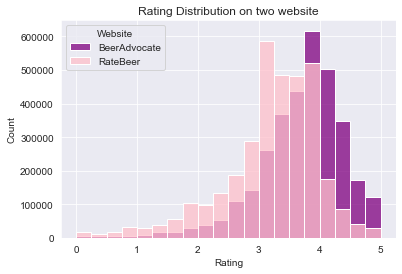

In [23]:
#creating subplots
ax=plt.subplots()

#plotting columns
ax=sns.histplot(data=df_rating_ba, x='rating', color = 'purple', binwidth=0.25, label='x')
ax=sns.histplot(data=df_rating_rb, x='rating', color = 'pink', binwidth=0.25)

# setting figure legend
plt.legend(title='Website', loc='upper left', labels=['BeerAdvocate', 'RateBeer'])

#renaming the axes
ax.set(xlabel="Rating", ylabel="Count")

# setting figute title
ax.set_title("Rating Distribution on two website")

# visualizing illustration
plt.show()

We can see that in this plot, rating on both websites are distributed like a normal distribution. There concentration of **rating** between 3-5 contributes to the majority.

#### Rating Distribution of Brewery
##### BeerAdvocate

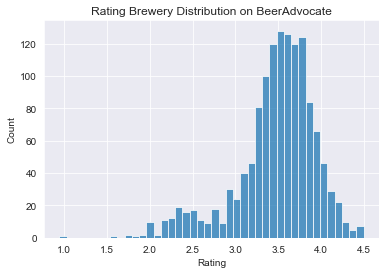

In [24]:
# explore ratings on each brewery
rating_brewery = pd.merge(df_rating_ba, df_brewery_ba, how='left', left_on='brewery_id', right_on='id')
rating_brewery = rating_brewery[['overall', 'brewery_name']]
mean_rating_brewery = rating_brewery.groupby('brewery_name').mean()
mean_rating_brewery = pd.DataFrame(mean_rating_brewery.to_records())

# draw rating brewery distribution
sns.histplot(data=mean_rating_brewery, x='overall')
plt.xlabel('Rating')
plt.title('Rating Brewery Distribution on BeerAdvocate')
plt.show()

##### RateBeer

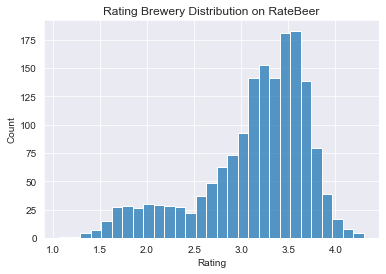

In [25]:
# explore ratings on each brewery
rating_brewery_rb = pd.merge(df_rating_rb, df_brewery_rb, how='left', left_on='brewery_id', right_on='id')
rating_brewery_rb = rating_brewery_rb[['overall', 'brewery_name']]
mean_rating_brewery_rb = rating_brewery_rb.groupby('brewery_name').mean()
mean_rating_brewery_rb = pd.DataFrame(mean_rating_brewery_rb.to_records())

# draw rating brewery distribution
sns.histplot(data=mean_rating_brewery_rb, x='overall')
plt.xlabel('Rating')
plt.title('Rating Brewery Distribution on RateBeer')
plt.show()

Generally, the distributions of brewery ratings on BeerAdvocate and RateBeer are similar. The majority of ratings fall between 3.0 and 4.0. But on RateBeer, there are relatively more ratings between 1.5 and 2.5.

#### Rating Distribution of the detailed scores

In [ ]:
data_title = ['appearance', 'aroma','palate','taste','overall']
plt.figure(figsize=(12,8))


for index, i in enumerate(data_title):

    #creating subplots
    ax=plt.subplot(2,3,index+1)

    #plotting columns
    ax=sns.histplot(data=df_rating_ba, x=i, color = 'purple', binwidth=0.25, label='x')
    ax=sns.histplot(data=df_rating_rb, x=i, color = 'pink', binwidth=0.25)

    # setting figure legend
    plt.legend(title='Website', loc='upper left', labels=['BeerAdvocate', 'RateBeer'])

    #renaming the axes
    ax.set(xlabel="Rating", ylabel="Count")

    # setting figute title
    ax.set_title(f"{i} Distribution on two website")

    # visualizing illustration
plt.tight_layout()
plt.show()

#### The abv rankings on the two datasets

In [ ]:
avg_ba_abv = region_ba.abv.mean()
avg_ba_abv = round(avg_ba_abv, 2)
print(f'The average abv% of beers from BeerAdvocate is {avg_ba_abv}%.')
fig, ax = plt.subplots()
ax.set_xlim(0, 20)
sns.histplot(region_ba.abv, binwidth=0.5, ax=ax)
plt.title("Abv rankings on BeerAdvocate")
plt.show()

In [ ]:
avg_rb_abv = region_rb.abv.mean()
avg_rb_abv = round(avg_rb_abv, 2)
print(f'The average abv% of beers from RateBeer is {avg_rb_abv}%.')
fig, ax = plt.subplots()
ax.set_xlim(0, 20)
sns.histplot(region_rb.abv, binwidth=0.5, ax=ax)
plt.title("Abv rankings on RateBeer")
plt.show()

According to the pictures above we found that the most popular beers has abv range from 4 to 10.

#### (Interactive) Find the popular beers in top 10 regions with the largest number of users in each year.
##### BeerAdvocate

In [ ]:
region_ba_style_change = region_ba[['date', 'location', 'beer_id', 'beer_name', 'brewery_id', 'brewery_name', 'overall', 'nbr_ratings', 'nbr_reviews', 'text', 'style']]

In [ ]:
region_ba_style_change['formal_date'] = region_ba_style_change.date.apply(lambda x: datetime.datetime.fromtimestamp(x))

In [ ]:
region_ba_style_change = region_ba_style_change[['formal_date', 'date', 'location', 'beer_id', 'beer_name', 'brewery_id', 'brewery_name', 'overall', 'nbr_ratings', 'nbr_reviews', 'text', 'style']]

In [ ]:
region_ba_style_change.formal_date.describe(datetime_is_numeric=True)

In [ ]:
region_ba_style_change.sort_values('formal_date', inplace=True)
region_ba_style_change['year'] = region_ba_style_change.formal_date.apply(lambda x: x.year)
region_list = region_agg.location.to_list()
year_list = region_ba_style_change.year.unique()
region_list = region_list[:10]

In [ ]:
# since there may have insufficient in early years, we want to make an alert in the interactive graph
def popup(text):
    display(HTML("<script>alert('{}');</script>".format(text)))

In [ ]:
def plot_interactive(region, year):
    data_to_plot = region_ba_style_change[(region_ba_style_change.location==region) & (region_ba_style_change.year==year)][['brewery_name', 'style', 'beer_name','overall']]
    data_to_plot = data_to_plot.groupby('style').mean().reset_index()
    data_to_plot = data_to_plot.sort_values('overall', ascending=False).head(10)
    if len(data_to_plot) > 0:
        sns.barplot(y='style', x='overall', data=data_to_plot, palette="magma")
        plt.title(f'10 beer styles in {region} that are the most popular in year {year}.')
        plt.xlabel('Overall score')
        plt.ylabel('Beer style')
        plt.show()
    else:
        popup(f"Insufficient data for {region} in {year}.")


interact(plot_interactive, region=region_list, year=year_list[:])


##### RateBeer

In [ ]:
region_rb_style_change = region_rb[['date', 'location', 'beer_id', 'beer_name', 'brewery_id', 'brewery_name', 'overall', 'nbr_ratings', 'text', 'style']]

In [ ]:
region_rb_style_change['formal_date'] = region_rb_style_change.date.apply(lambda x: datetime.datetime.fromtimestamp(x))

In [ ]:
region_rb_style_change = region_rb_style_change[['formal_date', 'date', 'location', 'beer_id', 'beer_name', 'brewery_id', 'brewery_name', 'overall', 'nbr_ratings', 'text', 'style']]

In [ ]:
region_rb_style_change.formal_date.describe(datetime_is_numeric=True)

In [ ]:
region_rb_style_change.sort_values('formal_date', inplace=True)
region_rb_style_change['year'] = region_rb_style_change.formal_date.apply(lambda x: x.year)
region_list = region_agg.location.to_list()
year_list = region_rb_style_change.year.unique()
region_list = region_list[:10]

In [ ]:
def plot_interactive(region, year):
    data_to_plot = region_rb_style_change[(region_rb_style_change.location==region) & (region_rb_style_change.year==year)][['brewery_name', 'style', 'beer_name','overall']]
    data_to_plot = data_to_plot.groupby('style').mean().reset_index()
    data_to_plot = data_to_plot.sort_values('overall', ascending=False).head(10)
    if len(data_to_plot) > 0:
        sns.barplot(y='style', x='overall', data=data_to_plot, palette="magma")
        plt.title(f'10 beer styles in {region} that are the most popular in year {year}.')
        plt.xlabel('Overall score')
        plt.ylabel('Beer style')
        plt.show()
    else:
        popup(f"Insufficient data for {region} in {year}.")


interact(plot_interactive, region=region_list, year=year_list[:])

#### Find the change of number of ratings
##### (interactive) Of each style of beers
###### BeerAdvocate

In [ ]:
beer_style_list = region_ba_style_change['style'].groupby(region_ba_style_change['style']).agg('count')
beer_style_list.sort_values(ascending=False)
beer_style_list = np.array(beer_style_list.index.to_list())

In [ ]:
def plot_year_vs_no_ratings_interactive(style):
    specific_style = style
    specific_style_region_by = region_ba_style_change[region_ba_style_change['style']==specific_style]
    specific_style_region_by = specific_style_region_by.dropna(how='any')
    specific_style_region_by = specific_style_region_by.drop_duplicates('year')
    sns.lineplot(data=specific_style_region_by, x='year', y='nbr_ratings')
    plt.title(f'The number of ratings of {style}')
    plt.xlabel('Year')
    plt.ylabel('Number of ratings')
    plt.show()

interact(plot_year_vs_no_ratings_interactive, style=beer_style_list)

###### RateBeer

In [ ]:
beer_style_list_rb = region_rb_style_change['style'].groupby(region_rb_style_change['style']).agg('count')
beer_style_list_rb.sort_values(ascending=False)
beer_style_list_rb = np.array(beer_style_list_rb.index.to_list())

In [ ]:
import warnings
warnings.filterwarnings('ignore')
def plot_year_vs_no_ratings_interactive(style):
    specific_style = style
    specific_style_region_by = region_ba_style_change[region_rb_style_change['style']==specific_style]
    specific_style_region_by = specific_style_region_by.dropna(how='any')
    specific_style_region_by = specific_style_region_by.drop_duplicates('year')
    sns.lineplot(data=specific_style_region_by, x='year', y='nbr_ratings')
    plt.title(f'The number of ratings of {style}')
    plt.xlabel('Year')
    plt.ylabel('Number of ratings')
    plt.show()

interact(plot_year_vs_no_ratings_interactive, style=beer_style_list_rb)

##### Total number of ratings on the websites and overall scores
###### BeerAdvocate

In [ ]:
plt.plot(region_ba_style_change.groupby(['year']).count()['formal_date'].index, region_ba_style_change.groupby(['year']).count()['formal_date'])
plt.ylabel('Number of views')
plt.xlabel('Year')
plt.title('Number of views over time')
plt.xticks([i for i in range(1998, 2018)], rotation=45)
plt.show()

According the image above, the number of views are increase over time. In 2014, it has the largest number of reviews. But after that, the number of views are keep decreasing. It can be noted that the number of evaluations suddenly doubled before 2013 and 2014, but it is not possible to analyse what caused this.

In [ ]:
# The bootstrapping function to use
def bootstrapping(array, num_of_iters: int, sample_rate: float, confidence_level: float, value='mean', replace=True,test=False):
    """array: takes in an array of your concern(numpy array)
        num_of_iters: the number of iterations you want to bootstrap
        sample_rate: the percentage of data to be sampled each time
        confidence_level: the confidence interval, e.g. 95%(input as 0.95)
        value: which value to calculate(be bootstrapped) mean / median
        replace: takes a boolean, if we will replace or not

        output: e.g. 95% confidence intervals of the mean

        Author: ZHANG Yuyao
        """
    if test:
        # array = np.array(array)
        if value=='mean':
            true_value = np.mean(array)
        elif value == 'median':
            true_value = np.median(array)
        print(f'The true value of {value} is {true_value}')

    sample_value = []
    data_len = len(array)
    sample_len = int(data_len*sample_rate)
    for i in range(num_of_iters):
        y = np.random.choice(array.tolist(), sample_len, replace=replace)
        if value=='mean':
            value_ = np.mean(y)
        elif value == 'median':
            value_ = np.median(y)
        sample_value.append(value_)

    bs_value = np.mean(sample_value)

    alpha = 1-confidence_level
    sample_value = np.sort(sample_value)

    left = np.percentile(sample_value, alpha*50)#(100/2)
    right = np.percentile(sample_value, 100-alpha*50)

    # print(f'The {value} is {bs_value}.\nAnd the {confidence_level} confidence interval for that is: ({left}, {right}).')
    return bs_value, left, right

In [ ]:
def get_stats_num_by_time(x):
    bs = bootstrapping(x['overall'], 1000, 0.1, 0.95)
#     print(bs[1])
    return pd.Series({'mean': bs[0],
                  'left':bs[1],
                  'right':bs[2]})

In [93]:
def get_stats_num_by_time(x):
    bs = bootstrapping(x['overall'], 1000, 0.1, 0.95)
#     print(bs[1])
    return pd.Series({'mean': bs[0],
                  'left':bs[1],
                  'right':bs[2]})

In [96]:
stats_to_plot_ba = region_ba_style_change.groupby(['year']).apply(lambda x: get_stats_num_by_time(x))

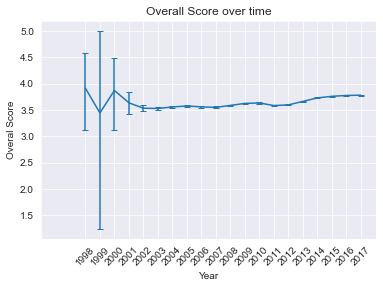

In [83]:
plt.errorbar(stats_to_plot_ba.index, stats_to_plot_ba['mean'],
             yerr = [stats_to_plot_ba['mean']-stats_to_plot_ba.left,
                     stats_to_plot_ba.right-stats_to_plot_ba['mean']],
             capsize=3)
# plt.plot(region_ba_style_change.groupby(['year']).mean()['overall'].index, region_ba_style_change.groupby(['year']).mean()['overall'])
plt.ylabel('Overal Score')
plt.xlabel('Year')
plt.title('Overall Score over time')
plt.xticks([i for i in range(1998, 2018)], rotation=45)
plt.show()

It is easy to notice it has very high overall score in 1999. But after analysis the data, we notice it only have few reviews in 1999, so it make a illusion that sudden rise in ratings.

###### RateBeer

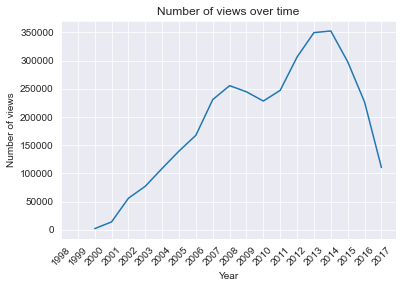

In [75]:
plt.plot(region_rb_style_change.groupby(['year']).count()['formal_date'].index, region_rb_style_change.groupby(['year']).count()['formal_date'])
plt.ylabel('Number of views')
plt.xlabel('Year')
plt.title('Number of views over time')
plt.xticks([i for i in range(1998, 2018)], rotation=45)
plt.show()

The number of views are keep increase until 2016.

In [97]:
stats_to_plot_rb = region_rb_style_change.groupby(['year']).apply(lambda x: get_stats_num_by_time(x))

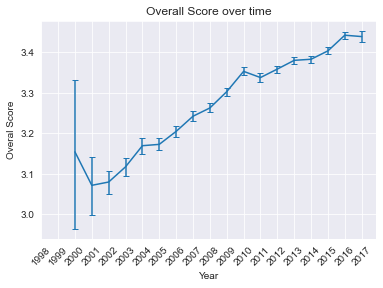

In [82]:
plt.errorbar(stats_to_plot_rb.index, stats_to_plot_rb['mean'],
             yerr = [stats_to_plot_rb['mean']-stats_to_plot_rb.left,
                     stats_to_plot_rb.right-stats_to_plot_rb['mean']],
             capsize=3)
# plt.plot(region_rb_style_change.groupby(['year']).mean()['overall'].index, region_rb_style_change.groupby(['year']).mean()['overall'])
plt.ylabel('Overal Score')
plt.xlabel('Year')
plt.title('Overall Score over time')
plt.xticks([i for i in range(1998, 2018)], rotation=45)
plt.show()

The overall score are keep increasing. In 2017 it was almost 2 points higher than the year of 2000.

#### Relation between the overall and 4 scores
##### BeerAdvocate

##### RateBeer

##### RateBeer

#### Hypothesis test about change in overall score
##### RateBeer
We observed that in the RateBeer dataset, the overall score has increased over the years.
Therefore, we want to conduct a hypothesis test about whether it really changed.

First, we split the data by the year 2011. (by experiment we find that the number of reviews are relatively close before and after this time point.

#### Hypothesis test about change in overall score
##### RateBeer
We observed that in the RateBeer dataset, the overall score has increased over the years.
Therefore, we want to conduct a hypothesis test about whether it really changed.
$\\$
First, we split the data by the year 2011. (by experiment we find that the number of reviews are relatively close before and after this time point.

In [52]:
region_rb_style_change_before2011 = region_rb_style_change[region_rb_style_change.year<=2011]['overall']
print(f'The number of reviews before 2011 is {len(region_rb_style_change_before2011)}.')

The number of reviews before 2011 is 1770869.


In [53]:
region_rb_style_change_after2011 = region_rb_style_change[region_rb_style_change.year>2011]['overall']
print(f'The number of reviews after 2011 is {len(region_rb_style_change_after2011)}.')

The number of reviews after 2011 is 1643671.


In [54]:
# we sample 1643671 data from before 2011 to make the dataset with the same
sample_before2011 = region_rb_style_change_before2011[:len(region_rb_style_change_after2011)]

In [55]:
hypo_test = stats.ttest_rel(sample_before2011, region_rb_style_change_after2011)

In [56]:
print(f'p value is {hypo_test.pvalue} here so we can reject the null hypothesis that the mean of the splited data are the same, so the overall score has really increased over the time.')

p value is 0.0 here so we can reject the null hypothesis that the mean of the splited data are the same, so the overall score has really increased over the time.


##### BeerAdvocate

In [57]:
region_ba_style_change_before2011 = region_ba_style_change[region_ba_style_change.year<=2014]['overall']
print(f'The number of reviews before 2011 is {len(region_ba_style_change_before2011)}.')
region_ba_style_change_after2011 = region_ba_style_change[region_ba_style_change.year>2014]['overall']
print(f'The number of reviews after 2011 is {len(region_ba_style_change_after2011)}.')
sample_before2011_ba = region_ba_style_change_before2011[:len(region_ba_style_change_after2011)]
hypo_test_ba = stats.ttest_rel(sample_before2011_ba, region_ba_style_change_after2011)
print(f'p value is {hypo_test_ba.pvalue} here so we can reject the null hypothesis that the mean of the splited data are the same, so the overall score has really increased over the time.')

The number of reviews before 2011 is 1637859.
The number of reviews after 2011 is 1629708.
p value is 0.0 here so we can reject the null hypothesis that the mean of the splited data are the same, so the overall score has really increased over the time.


Some reasons:


In the past, fewer people have access to the Internet, so as the rating websites. Therefore, the users may be some experts in beer or have great passion for beers. In this case, they might be more strict while rating the beers.
However, now we all can get online to rate the beers, so there exists user groups with higher diversity, which may leads to more relaxed standard, thus the score is higher.